## Opioid Epidemic Exploratory Data Analysis

### Objective: Explore with EDA the relationship between opioid mortality rate and the geo-spatial distribution and composition of substance abuse treatment facilities and services in the U.S. 

In [125]:
# Dependencies and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Plotly
import plotly.express as px
import plotly.graph_objects as go
#Scipy
import scipy.stats as sts
#Seaborn
import seaborn
#Pingouin
import pingouin as pg
from pingouin import pairwise_ttests

In [126]:
### Import opioid mortality rate dataset

health04_S_file_path = "../Resources/Health04/Health04_S.csv"
mortality_data = pd.read_csv(health04_S_file_path)
mortality_df = pd.DataFrame(mortality_data)
mortality_df.head(3)

G_STATEFP  STATEFP st_abb  st_name  opPrscRt19  prMisuse19  odMortRt14  \
0       G01        1     AL  Alabama        39.1        4.55        15.2   
1       G02        2     AK   Alaska        85.8        3.99        16.8   
2       G04        4     AZ  Arizona        80.9        3.80        18.2   

   odMortRt15  odMortRt16  odMortRt17  odMortRt18  odMortRt19  odMortRtAv  
0        15.7        16.2        18.0        16.6        16.3       16.33  
1        16.0        16.8        20.2        14.6        17.8       17.03  
2        19.0        20.3        22.2        23.8        26.8       21.72

In [127]:
### Create a dataframe with state abbreviation and opioid mortality rate from mortality_data

mort_df = mortality_df.loc[:,['st_abb', 'st_name', 'odMortRtAv']]
mort_df = mort_df.rename(columns={'st_abb' : 'STATE', 'st_name' : 'State Name', 'odMortRtAv' : 'odMortRtAv'})
mort_df.head(3)

STATE State Name  odMortRtAv
0    AL    Alabama       16.33
1    AK     Alaska       17.03
2    AZ    Arizona       21.72

### Visualize odMortRtAv by State with ployly choropleth map

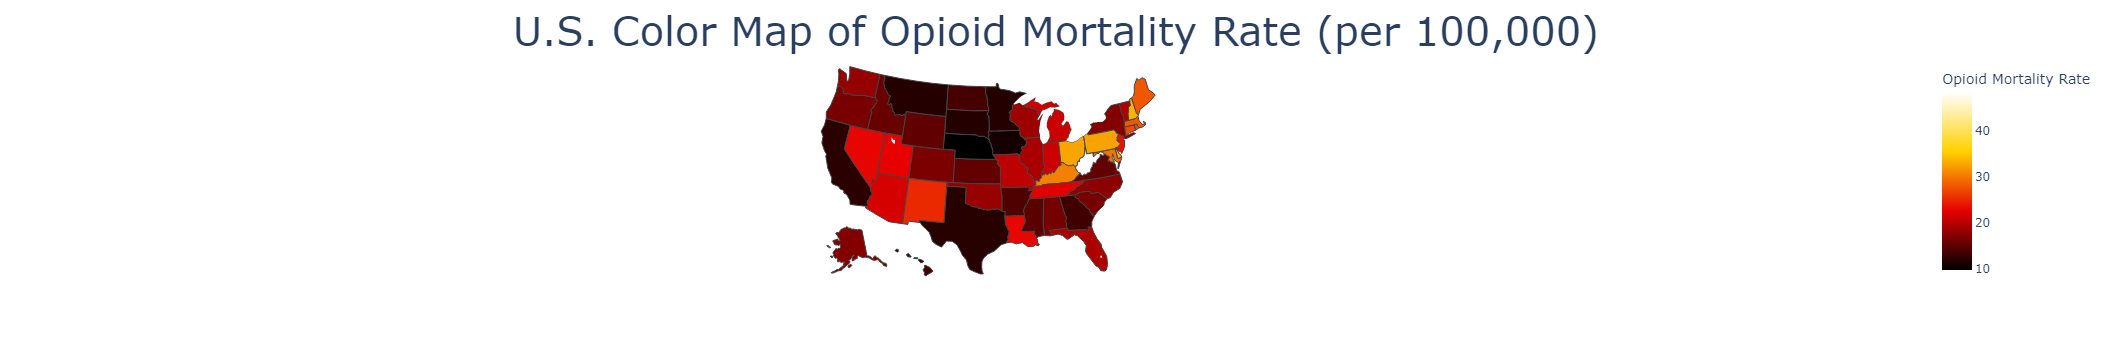

In [128]:
fig1 = px.choropleth(mort_df,
                    locations='STATE',
                    color='odMortRtAv',
                    color_continuous_scale='hot',
                    hover_name='State Name',
                    labels={'odMortRtAv':'Opioid Mortality Rate'},
                    locationmode='USA-states',
                    scope='usa')

fig1.update_layout(
    title=dict(text="U.S. Color Map of Opioid Mortality Rate (per 100,000)", x=0.5, y=.95), title_font_size = 40
)

fig1.show()

In [129]:
fig1.write_html('HTML/odMortRtAv_map.html', auto_open=True)

In [130]:
### Import region dataset

region_file_path = "../Resources/Geographic/state_region.csv"
region_data = pd.read_csv(region_file_path)
region_df = pd.DataFrame(region_data).loc[:,['State Code', 'Region', 'Division']].rename(columns={'State Code' : 'STATE', 'Region' : 'REGION', 'Division' : 'DIVISION'})
region_df.head(5)

### Merge mort and region dfs

mort_region_df = pd.merge(region_df, mort_df, on="STATE", how="inner")
mort_region_df.head(3)

### Import treatment facility dataset

nssats_file_path = "../Resources/NSSATS/NSSATS_PUF_2020_CSV.csv"

facility_data = pd.read_csv(nssats_file_path, low_memory=False)
facility_data.head(3)

facility_df = pd.DataFrame(facility_data)
facility_df.shape

### Remove Jurisdictions not included in Health04 dataset

rejected_state_codes = ['PR', 'ZZ']
facility_rejected_state_s = facility_df.STATE.isin(rejected_state_codes)
facility_rejected_state_s

facility_df[~facility_rejected_state_s] #with or without loc same output

fac_df = facility_df.loc[~facility_df.STATE.isin(rejected_state_codes)]
fac_df

fac_df = facility_df.loc[facility_df.STATE != 'PR'].loc[facility_df.STATE != 'ZZ']
fac_df.STATE.nunique()

### Merge mortality and facility dfs

df = pd.merge(mort_region_df, fac_df, on = "STATE", how = "inner") 
print(df.shape)
df.head(3)

(15955, 266)


STATE REGION DIVISION State Name  odMortRtAv  CASEID  STFIPS  DETOX  \
0    AK   West  Pacific     Alaska       17.03       1       2      0   
1    AK   West  Pacific     Alaska       17.03       2       2      0   
2    AK   West  Pacific     Alaska       17.03       3       2      1   

   TREATMT  SMISEDSUD  ...  T_CLIHI_X  T_CLIML_D T_CLIML_O T_CLIML_X  \
0        1          1  ...        NaN        NaN       NaN       1.0   
1        1          1  ...        NaN        NaN       NaN       NaN   
2        1          0  ...        NaN        NaN       1.0       NaN   

   T_CLIOP_D  T_CLIOP_O  T_CLIOP_X  T_CLIRC_D  T_CLIRC_O  T_CLIRC_X  
0        NaN        NaN        4.0        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN        NaN        4.0  
2        NaN        1.0        NaN        NaN        NaN        NaN  

[3 rows x 266 columns]

## Visualize the number of substance abuse treatment facilities by state and region

### Create Dataframe with value_counts() of CASEID for number of facilities by State

In [131]:
n_facility_st_df = df.groupby('STATE', as_index=False)['CASEID'].nunique()
n_facility_st_df = n_facility_st_df.rename(columns={'STATE' : 'STATE', 'CASEID' : 'N Treatment Facilities'})
n_facility_st_df.head(3)

STATE  N Treatment Facilities
0    AK                     105
1    AL                     155
2    AR                     171

In [132]:
intro_df = pd.merge(mort_df, n_facility_st_df, on = 'STATE', how = 'inner')
intro_df['Facilties/odMortRtAv (per 100,000)'] = (intro_df['N Treatment Facilities'] / intro_df.odMortRtAv).round(0)
intro_df = intro_df.rename(columns={'STATE' : 'State Code', 'st_name' : 'State Name'})
intro_df.head(3)

State Code State Name  odMortRtAv  N Treatment Facilities  \
0         AL    Alabama       16.33                     155   
1         AK     Alaska       17.03                     105   
2         AZ    Arizona       21.72                     447   

   Facilties/odMortRtAv (per 100,000)  
0                                 9.0  
1                                 6.0  
2                                21.0

### Create Color Map for N Treatment Facilites by State

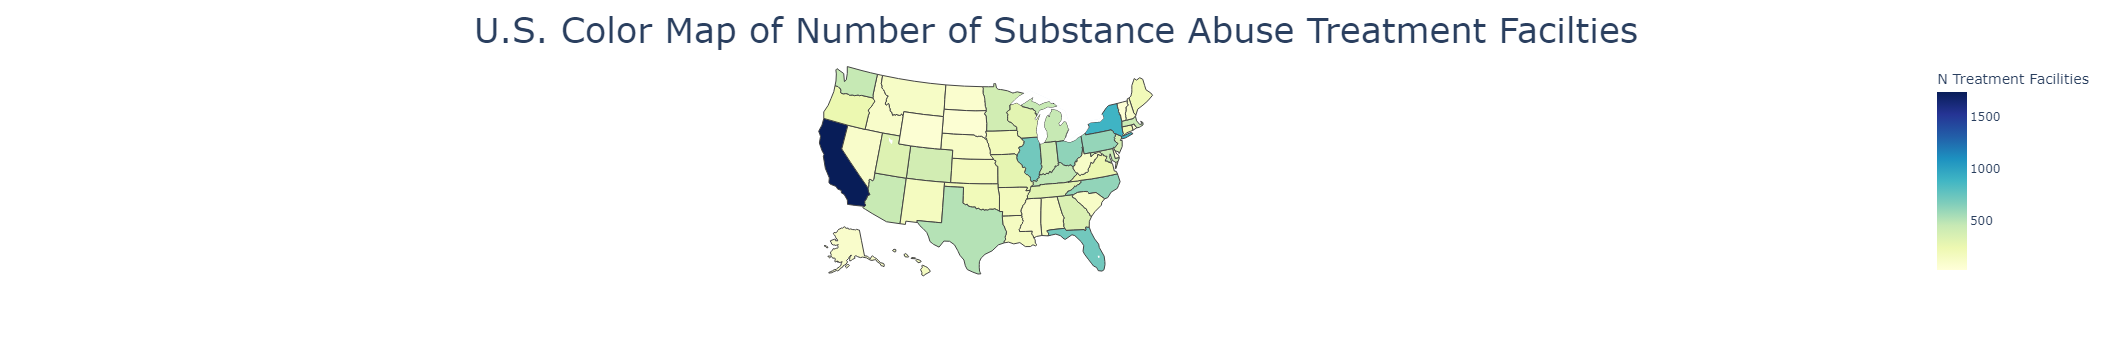

In [133]:
fig2 = px.choropleth(intro_df,
                    locations='State Code',
                    color='N Treatment Facilities',
                    color_continuous_scale='ylgnbu',
                    hover_name='State Name',
                    locationmode='USA-states',
                    labels={'Facilities/odMortRtAv (per 100,000)':'Facilities : Opioid Mortality'},
                    scope='usa')
fig2.update_layout(
    title=dict(text="U.S. Color Map of Number of Substance Abuse Treatment Facilties", x=0.5, y=.95), title_font_size = 35
)

fig2.show()

In [134]:
fig2.write_html('HTML/N_Facilities_map.html', auto_open=True)

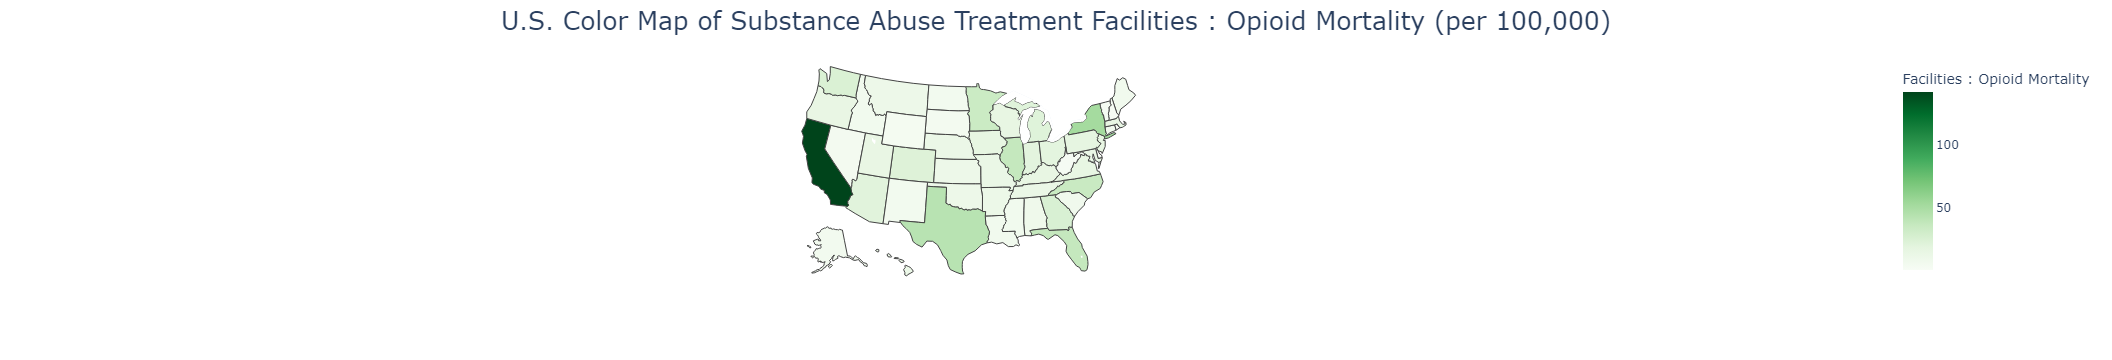

In [135]:
fig3 = px.choropleth(intro_df,
                    locations='State Code',
                    color='Facilties/odMortRtAv (per 100,000)',
                    color_continuous_scale='greens',
                    hover_name='State Name',
                    locationmode='USA-states',
                    labels={'Facilties/odMortRtAv (per 100,000)':'Facilities : Opioid Mortality'},
                    scope='usa')
fig3.update_layout(
    title=dict(text="U.S. Color Map of Substance Abuse Treatment Facilities : Opioid Mortality (per 100,000)", x=0.5), title_font_size = 25
)

fig3.show()

In [136]:
fig3.write_html('HTML/Facilities_odMortRtAv_map.html', auto_open=True)

## OTP: Facility operates an opioid treatment program

In [137]:
otp_df = df[df.OTP == 1]
otp_df.shape

(1747, 266)

### Apply same method to OTP subset

In [138]:
n_facility_st_df = otp_df.groupby('STATE', as_index=False)['CASEID'].nunique()
n_facility_st_df = n_facility_st_df.rename(columns={'STATE' : 'STATE', 'CASEID' : 'N Treatment Facilities w OTP'})
n_facility_st_df.head(3)

STATE  N Treatment Facilities w OTP
0    AK                             4
1    AL                            20
2    AR                             8

In [139]:
intro_df = pd.merge(mort_df, n_facility_st_df, on = 'STATE', how = 'inner')
intro_df['Facilties w OTP/odMortRtAv (per 100,000)'] = (intro_df['N Treatment Facilities w OTP'] / intro_df.odMortRtAv).round(0)
intro_df = intro_df.rename(columns={'STATE' : 'State Code', 'st_name' : 'State Name'})
intro_df.head(3)

State Code State Name  odMortRtAv  N Treatment Facilities w OTP  \
0         AL    Alabama       16.33                            20   
1         AK     Alaska       17.03                             4   
2         AZ    Arizona       21.72                            60   

   Facilties w OTP/odMortRtAv (per 100,000)  
0                                       1.0  
1                                       0.0  
2                                       3.0

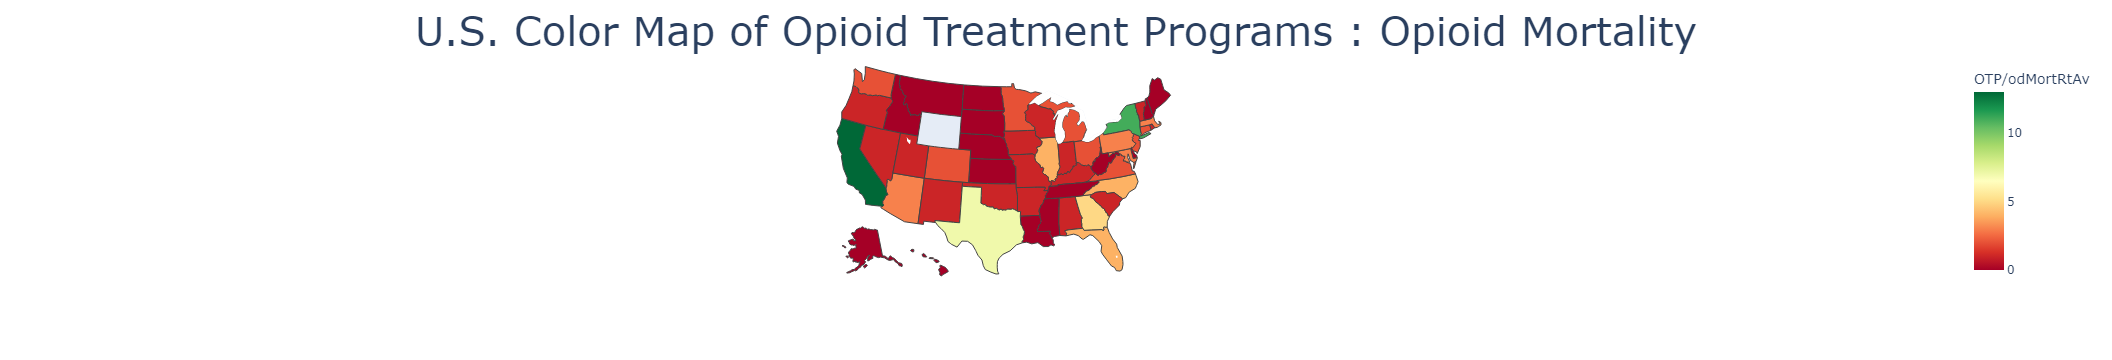

In [140]:
fig4 = px.choropleth(intro_df,
                    locations='State Code',
                    color='Facilties w OTP/odMortRtAv (per 100,000)',
                    color_continuous_scale='rdylgn',
                    hover_name='State Name',
                    locationmode='USA-states',
                    labels={'Facilties w OTP/odMortRtAv (per 100,000)':'OTP/odMortRtAv'},
                    scope='usa')
fig4.update_layout(
    title=dict(text="U.S. Color Map of Opioid Treatment Programs : Opioid Mortality", x=0.5, y=.95), title_font_size = 40)
    
fig4.show()

In [141]:
fig4.write_html('HTML/OTP_odMortRtAv_map.html', auto_open=True)

In [143]:
plotly_colorscales = px.colors.named_colorscales()